In [1]:
import numpy as np
import sys, os, pickle, h5py, time

from iminuit import Minuit
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from astropy import coordinates as coord

# Utility Methods

The main utility method is `rebin`, which functions identically to that in `Analyze_30keV.ipynb`. We additionally provide a utility method `hires_rebin`, which produces normalized, high resolution rebinning for plotting purposes.

In [2]:
def rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    interp_spectrum = np.interp(interp_energies, e, spectrum)

    
    interp_energies += E_Shift
    
    binned_spectrum = np.zeros_like(emins)
    for i in range(len(binned_spectrum)):
        
        min_index = np.searchsorted(interp_energies, emins[i])
        max_index = np.searchsorted(interp_energies, emaxs[i])
        
        binned_spectrum[i] = np.trapz(interp_spectrum[min_index:max_index], interp_energies[min_index:max_index])
        
    
    return np.nan_to_num(binned_spectrum) / binsize


def hires_rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    hires_binsize = np.diff(interp_energies)[0]
    
    interp_spectrum = np.interp(interp_energies, e, spectrum, left = 0, right = 0)
    
    
    interp_spectrum /= np.sum(interp_spectrum * hires_binsize*exposure)
    
    return interp_energies, interp_spectrum

# Load the Data

In this notebook we perform the analysis over the full 0-210 keV data presented in Fig. 3 of 2006.09721. We analyze the stacked data, provided in `Stacked_Data_210keV.h5` and also perform a joint likelihood analysis of the SR1$_\mathrm{a}$ and SR1$_\mathrm{b}$ data sets, provided in `Joint_Data_210keV.h5`. In the analysis of the stacked data, we refit our own background model which is obtained by refitting the individual model components that contributed to the summed background, provided in `ModelArchive.h5`.

In [3]:
exposure = .658

stacked_archive = h5py.File('../Data/Stacked_Data_210keV.h5', 'r', driver="core")
joint_archive = h5py.File('../Data/Joint_Data_210keV.h5', 'r', driver="core")
model_archive = h5py.File('../Data/ModelArchive.h5', 'r', driver="core")

e_centers = np.array((stacked_archive['BinEdges'][1:] + stacked_archive['BinEdges'][:-1]) / 2)
emins = np.array(stacked_archive['BinEdges'][:-1])
emaxs = np.array(stacked_archive['BinEdges'][1:])
binsize = np.diff(e_centers)[0]


ens_ABC = np.array(model_archive['ABC_Model'][0])
flux_ABC = np.array(model_archive['ABC_Model'][1])

# Analysis of the Stacked SR1 Data

We begin with our analysis of the stacked SR1 data using our refit backgrounds

In [4]:
stacked_flux = np.array(stacked_archive['Flux'])
stacked_error = np.array(stacked_archive['FluxError'])

central_values = np.array(stacked_archive['Prior_Centers'])
std = np.array(stacked_archive['Prior_STD'])
bkg_component_data = np.array(stacked_archive['BackgroundComponents'])

Here we construct a binned likelihood in the form of a negative log-likelihood. The function `objective` accepts a parameter vector `x`, which specifies the number of expected counts contributed by each model component (a shifted ABC spectrum and the background component spectra). The shifted ABC spectrum is specified by the argument `abc_spectrum`. By default, we mask out the first bin of the data.

In [5]:
def objective(x, abc_spectrum):
    
    signal = x[0]* abc_spectrum
    x = x[1:]

    prior_locs = np.where(std > 0)
    prior = np.sum((x- central_values)[prior_locs]**2 / std[prior_locs]**2)

    background = np.sum(x[:, None] * bkg_component_data, axis = 0)

    expected = background + signal
    chiSq =  np.sum((stacked_flux -expected)[1:]**2 / stacked_error[1:]**2)

    return chiSq + prior, expected

Here we determine our best fit background model in absence of signal by fixing the `x0` parameter, which corresponds to the expected counts contributed by the ABC spectrum.

In [6]:
# Constructing the initial guess and parameter bounds for the optimization
guess = np.append(0, np.array(stacked_archive['Prior_Centers']))
limits = np.vstack(([-2000, 2000], np.array(stacked_archive['Param_Bounds'])))

m = Minuit.from_array_func(lambda x: objective(x, 0)[0], guess, limit=limits,
                           error = np.minimum(1, .1 * np.diff(limits, axis = 1)),
                           errordef = 1e0)
m.fixed['x0'] = True
m.migrad()

bkg_fit = np.array(m.values.values()) # best fit amplitudes for the background components
refit_bkg = objective(np.array(m.values.values()), 0)[1] # the best fit background 

### Plot the Best Fit Background and Compare to Data

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


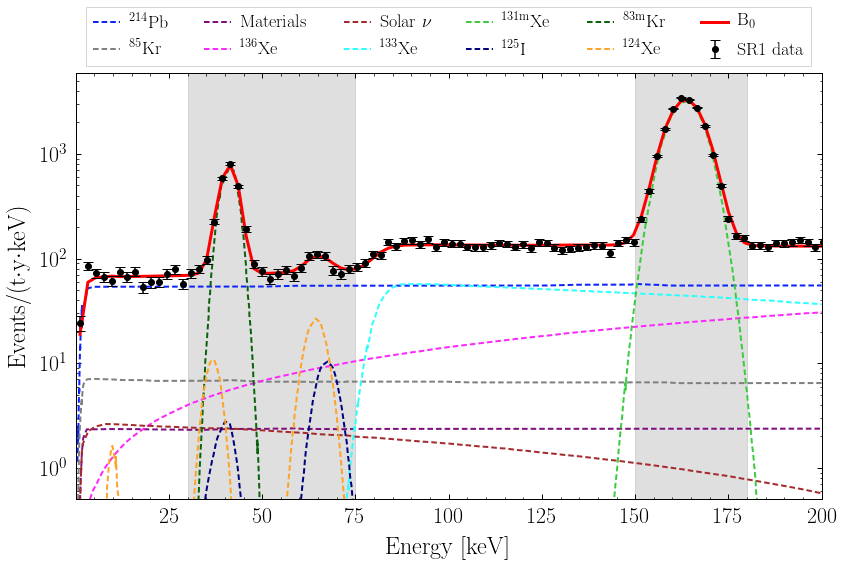

In [7]:
label_list = [r'$^{214}$Pb', r'$^{85}$Kr', r'Materials', r'$^{136}$Xe', r'Solar $\nu$',
              r'$^{133}$Xe', r'$^{131\mathrm{m}}$Xe', r'$^{125}$I', r'$^{83\mathrm{m}}$Kr',
              r'$^{124}$Xe']

color_list = [np.array([11, 36, 251]) / 255, np.array([128, 128, 128]) / 255, np.array([127, 15, 126]) / 255,
              np.array([252, 40, 252]) / 255, np.array([163, 43, 46]) / 255, np.array([45, 255, 254]) / 255,
              np.array([60, 203, 62]) / 255, np.array([2,2, 126]) / 255, np.array([9, 99, 12]) / 255,
              np.array([253, 164, 40]) / 255]

# Figure size
mpl.rcParams['figure.figsize'] = 12, 8
ax = plt.subplot(111)

for i in range(len(label_list)):
    ax.plot(np.array(stacked_archive['HiResEnergies'][i]),
            m.values['x' + str(i+1)]*np.array(stacked_archive['HiResFlux'][i]),
            ls = '--', lw = 2, color = color_list[i], label = label_list[i])

ax.plot(e_centers, refit_bkg, c = 'red', lw =3,
         label = 'B$_0$')

ax.errorbar(e_centers, stacked_archive['Flux'], stacked_archive['FluxError'], c = 'black', fmt ='o', capsize = 5,
             label = 'SR1 data')
   


ax.axvspan(30, 75, color="grey", alpha = .25)
ax.axvspan(150, 180, color="grey", alpha = .25)


ax.set_yscale('log')
ax.set_ylim(5e-1, None)
ax.set_xlim(0, 200)
ax.set_xticks([25, 50, 75, 100, 125, 150, 175, 200])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175),
          ncol=6, fancybox=False, shadow=False, fontsize = 18)

plt.xlabel('Energy [keV]')
plt.ylabel('Events/(t$\cdot$y$\cdot$keV)')
#ax.set_xlim(150, 180)
plt.tight_layout()
plt.savefig('../Plots/Fig5.pdf')

plt.show()

Now we compute the $\Delta \chi^2$ associated with the inclusion of a shifted ABC spectrum as a function of shift energy using our refit background.

In [8]:
def StackedChiSq(E_Shift, mask = True):
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    By default, the first signal bin is masked out. This option can be toggled with the optional
    argument `mask`.
    
    Return the best fit signal amplitude and the change in chi^2 statistic.
    '''
    
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(e_centers)[0]*exposure))
    
    if mask:
        abc_spectrum[np.where(emins < 1 + E_Shift)] = 0
    
    # First, do the fit using the refit background model
    m = Minuit.from_array_func(lambda x: objective(x, abc_spectrum)[0], guess, limit = limits,
                               error = 1e-2*(limits[:, 1] - limits[:, 0]), errordef = 1e0)
    m.fixed['x0'] = True
    m.migrad()
    NullChiSq = m.fval
    
    
    # Next, fix the continuum params and fit a signal model
    for i in range(len(guess)):
        if i == 0:
            m.fixed['x' + str(i)] = False
        else:
            m.fixed['x'+str(i)] = True
            
    m.migrad()

    SignalChiSq = m.fval
    
    FixedTS = NullChiSq - SignalChiSq
    
    
    # First, do the fit using the refit background model
    m = Minuit.from_array_func(lambda x: objective(x, abc_spectrum)[0], bkg_fit, limit = limits,
                               error = 1e-1*(limits[:, 1] - limits[:, 0]), errordef = 1e0)
    m.migrad()
    ProfiledChiSq = m.fval
    
    ProfiledTS = NullChiSq - ProfiledChiSq
    return FixedTS, ProfiledTS

In [9]:
Stacked_TS_Values = np.zeros((3201, 2))
E_Shifts = np.linspace(0, 200, 3201)

for i in range(len(E_Shifts)):
    Stacked_TS_Values[i]= StackedChiSq(E_Shifts[i])

# Joint Likelihood Analysis

Next we perform a joint likelihood analysis of the binned SR1$_{a}$ and SR1$_{b}$ data. We additionally perform independent analyses of the SR1$_{a}$ and SR1$_{b}$ data.

In [10]:
joint_fluxes = np.array(joint_archive['Flux'])
joint_errors =np.array(joint_archive['FluxError'])
joint_bkgs = np.array(joint_archive['X1T_Background'])

In [11]:
# This method calculates the improvement to the \Delta \chi^2 on the joint data
def JointChiSq(E_Shift, mask = True):
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    By default, the first signal bin is masked out. This option can be toggled with the optional
    argument `mask`.
    
    Return the best fit signal amplitude and the change in chi^2 statistic.
    '''
    
    def objective(x, abc_spectrum):
        return np.sum((joint_fluxes - x * abc_spectrum - joint_bkgs)[:, 1:]**2 / joint_errors[:, 1:]**2)
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(emins)[0]*exposure))
    
    if mask:
        abc_spectrum[np.where(emins <= 1 + E_Shift)] = 0
    
    NullChiSq = objective(0, 0)
    
    n = Minuit(lambda x: objective(x, abc_spectrum), x = 0, error_x = 1, limit_x = [None, None], errordef = 1)
    n.migrad()

    return NullChiSq - n.fval

# This method calculates the improvement to the \Delta \chi^2 to for shifted ABC spectrum
# fit indpendently to one of the two SR1_a and SR1_b datasets, specified by index 
def IndependentChiSq(E_Shift, index, mask = True):
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    By default, the first signal bin is masked out. This option can be toggled with the optional
    argument `mask`.
    
    Return the best fit signal amplitude and the change in chi^2 statistic.
    '''
    
    
    def objective(x, abc_spectrum):
        return np.sum((joint_fluxes - x * abc_spectrum - joint_bkgs)[index, 1:]**2 / joint_errors[index, 1:]**2)
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(emins)[0]*exposure))
    
    if mask:
            abc_spectrum[np.where(emins <= 1 + E_Shift)] = 0
        
    NullChiSq = objective(0, 0)
    
    n = Minuit(lambda x: objective(x, abc_spectrum), x = 0, error_x = 1, limit_x = [None, None], errordef = 1)
    n.migrad()

    return NullChiSq - n.fval

In [12]:
Joint_TS = np.zeros_like(E_Shifts)

for i in range(E_Shifts.shape[0]):
    Joint_TS[i] = JointChiSq(E_Shifts[i])


Independent_TS = np.zeros((len(E_Shifts), 2))
for i in range(E_Shifts.shape[0]):
    Independent_TS[i, 0] = IndependentChiSq(E_Shifts[i], 0)
    Independent_TS[i, 1] = IndependentChiSq(E_Shifts[i], 1)

# Make Various Plots

Fig 2: A comparison of the refit background model to data and the $\Delta \chi^2$ as a function of the energy shift of the ABC spectrum for the stacked data with refit background and for the SR1$_a$ and SR1$_b$ datasets using the fixed XENON1T background models when independently and jointly fit. For default settings, this plot slightly differs from that in the manuscript, where the $\Delta \chi^2$ is evaluated without masking the first signal bin. Results are qualitatively unchanged, and the impact of including the first signal bin can be tested by modifying the `mask` optional arguments in the functions above which calculate $\Delta \chi^2$

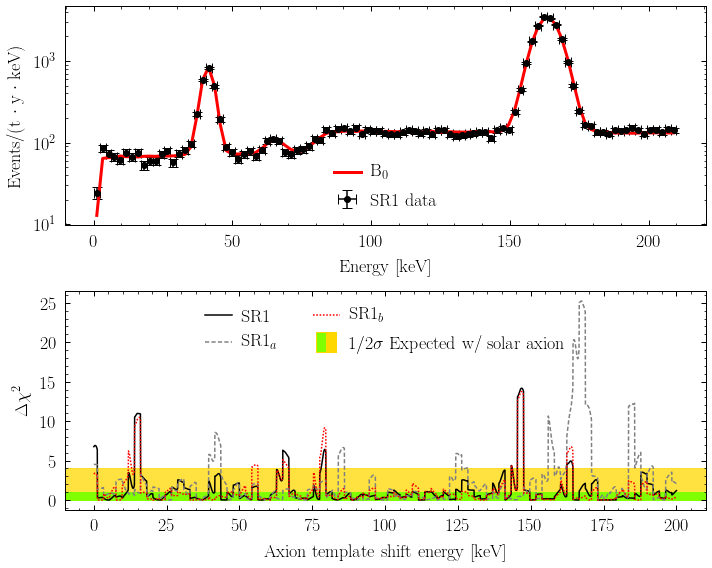

In [13]:
fig, axs = plt.subplots(nrows = 2,figsize=(10,8))

fontsize=18


axs[0].errorbar(e_centers, stacked_archive['Flux'], yerr = stacked_archive['FluxError'],
                xerr = binsize/2, c = 'black', fmt ='o', capsize = 5, label = 'SR1 data')
axs[0].plot(e_centers, stacked_archive['X1T_Background'], lw = 3, c = 'red',
            label = 'B$_0$')

axs[0].set_xlabel('Energy [keV]',fontsize=fontsize)
axs[0].set_ylabel(r'Events/(t $\cdot$ y $\cdot$ keV)',fontsize=fontsize)
axs[0].set_yscale('log')
axs[0].legend(frameon = False, loc = 'lower center', fontsize =fontsize)
   

axs[1].plot(E_Shifts, Joint_TS, c = 'black', zorder = 11, label = 'SR1')
axs[1].plot(E_Shifts, Independent_TS[:, 0], c = 'grey', ls = '--',
            zorder = 11, label = 'SR1$_{a}$')
axs[1].plot(E_Shifts, Independent_TS[:, 1], c = 'red', ls = ':',
            zorder = 11, label = 'SR1$_{b}$')

axs[1].axhspan(0, 4, color = 'gold', alpha = .75)
axs[1].axhspan(0, 1, color = 'chartreuse', alpha = 1.)


axs[1].set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs[1].set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)




msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = axs[1].get_legend_handles_labels()
handles1 = [handles[0], handles[1], handles[2], (m3 ,m4)]
labels1 = [labels[0], labels[1], labels[2],  r'$1/2\sigma$ Expected w/ solar axion']

axbox = axs[1].get_position()
x_value= -0.1
y_value= .65

legend1 = axs[1].legend(handles1,labels1, frameon=False, fontsize = fontsize,
                        ncol = 2, loc = 'upper center')


axs[0].tick_params(axis='x', labelsize= fontsize)
axs[0].tick_params(axis='y', labelsize= fontsize)
axs[1].tick_params(axis='x', labelsize= fontsize)
axs[1].tick_params(axis='y', labelsize= fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace = .3)

plt.savefig('../Plots/Fig2.pdf')
plt.show()

Fig 3: A comparison of survival functions of the $\chi^2$ statistic using the refit background on the stacked data (with and without profiling) and in the joint likelihood

In [14]:
mask = np.where(E_Shifts <= 7)
accepted_locs = np.setdiff1d(np.arange(len(E_Shifts)), mask)

/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleD

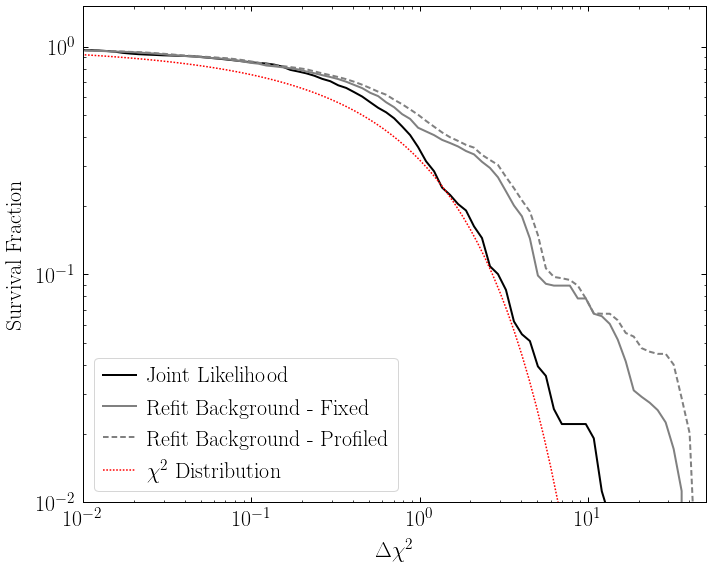

In [15]:
# Figure size
mpl.rcParams['figure.figsize'] = 10, 8

fontsize=22#18

#num_bins = 20
bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Joint_TS[accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Joint Likelihood", c = 'black', lw = 2)


bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Stacked_TS_Values[:, 0][accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Refit Background - Fixed", c = 'grey', lw = 2)

bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Stacked_TS_Values[:, 1][accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Refit Background - Profiled", c = 'grey', lw = 2, ls = '--')


x_vals = np.geomspace(1e-3, 2e1, 100)
y_vals = stats.chi2.sf(x_vals, df = 1)

plt.plot(x_vals, y_vals, c='black',color="red",linestyle="dotted", label = r'$\chi^2$ Distribution')

plt.ylim(1e-2, 1.5)
plt.xlim(1e-2, 50)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(ncol = 1, fontsize = fontsize,loc=3)
plt.xlabel(r'$\Delta \chi^2$',fontsize=fontsize)
plt.ylabel(r'Survival Fraction',fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('../Plots/Fig3.pdf')

Fig 6: The $\Delta \chi^2$ as a function of shift energy over the 0-210 keV range evaluated in the joint likelihood and on the stacked data (with and without profiling the background).

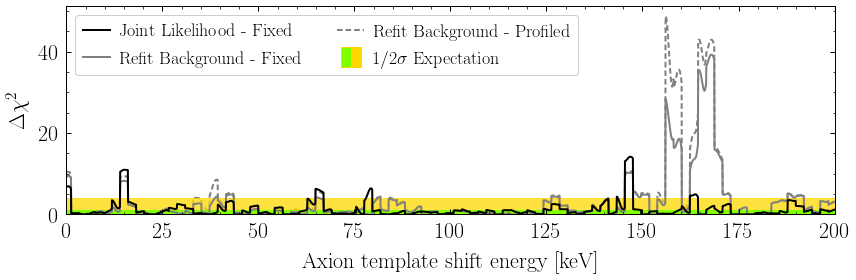

In [16]:
fig, axs = plt.subplots(nrows = 1,figsize=(12,4))

fontsize=22

axs.plot(E_Shifts, Joint_TS, c = 'black', zorder = 10, label = 'Joint Likelihood - Fixed', lw = 2)


axs.plot(E_Shifts, Stacked_TS_Values[:, 0], c = 'grey', zorder = 1,
         label = 'Refit Background - Fixed', lw = 2)
axs.plot(E_Shifts, Stacked_TS_Values[:, 1], c = 'grey', ls = '--', zorder = 0,
         label = 'Refit Background - Profiled', lw = 2)


axs.axhspan(0, 4, color = 'gold', alpha = .75)
axs.axhspan(0, 1, color = 'chartreuse', alpha = 1.)


axs.set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs.set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)
axs.legend()



msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)
 
handles,labels = axs.get_legend_handles_labels()
handles1 = [handles[0], handles[1], handles[2], (m3 ,m4)]
labels1 = [labels[0], labels[1], labels[2], r'$1/2\sigma$ Expectation']

axbox = axs.get_position()
x_value= -0.1
y_value= .65

legend1 = axs.legend(handles1,labels1, loc='upper left',frameon=True,
                     fontsize = fontsize-4, framealpha = 1., ncol = 2)


axs.set_ylim(0, None)

axs.set_xlim(0,200)
axs.tick_params(axis='x', labelsize= fontsize)
axs.tick_params(axis='y', labelsize= fontsize)
plt.tight_layout()
plt.savefig('../Plots/Fig6.pdf')
plt.show()